# Final compare for the course.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io as si
import deepcell

from deepcell.metrics import Metrics

In [7]:
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
## path containing data and predictions
gold_path = 'data/goldstandard/20201018_multiplex_seed_1_val_256x256.npz'
deepcell_path = 'data/deepcell/prediction_of_20201018_multiplex_seed_1_val_256x256.npy'
cellpose_path = 'data/cellpose/'

In [3]:
# load gold standard
gold_standard = np.load(gold_path)
X_gold = gold_standard['X']
y_gold = gold_standard['y']

# load predictions from deepcell
pred_dpc = np.load(deepcell_path)
y_dpc = pred_dpc[...,0]
print("deepcell: y_dpc shape:{}, y_dpc.dtype:{}".format(y_dpc.shape, y_dpc.dtype))

# load predictions from cellpose
pred_cellpose = [i for i in os.listdir(cellpose_path) if i[-5:] == 's.png']
pred_cellpose.sort()
pred_cellpose_pic = [si.imread(os.path.join(cellpose_path, pic)) for pic in pred_cellpose]
y_cps = np.zeros([100,256,256],dtype='uint16')
for i in range(100):
    y_cps[i] = np.array(pred_cellpose_pic[i])
print("cellpose: y_cps shape:{}, y_cps.dtype:{}".format(y_cps.shape, y_cps.dtype))

deepcell: y_dpc shape:(3224, 256, 256), y_dpc.dtype:int32
cellpose: y_cps shape:(100, 256, 256), y_cps.dtype:uint16


### Visualize the predictions of CellPose and DeepCell

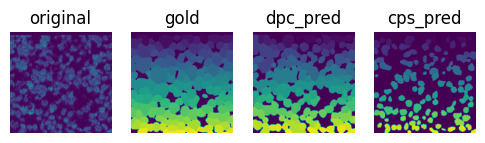

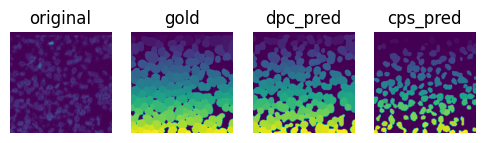

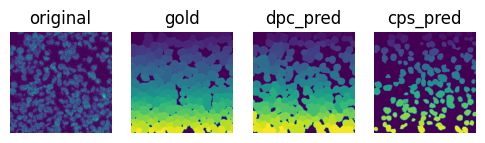

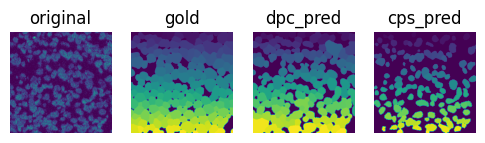

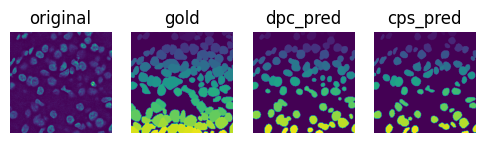

In [4]:
for i in range(5):
    plt.figure(i, dpi = 100)
    plt.subplot(141)
    plt.imshow(X_gold[i,...,0].astype('float64'))
    plt.title("original")
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(y_gold[i,...,0].astype('float64'))
    plt.title("gold")
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(y_dpc[i])
    plt.title("dpc_pred")
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(y_cps[i])
    plt.title("cps_pred")
    plt.axis('off')

### Evaluate CellPose predictions

In [5]:
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
cps_tab = m.calc_object_stats(y_gold[:100,:,:,0], y_cps[:100]) # y_true, y_pred

100%|██████████| 100/100 [00:04<00:00, 22.69it/s]
/home/qukun/ly0613/miniconda/envs/testenv/lib/python3.6/site-packages/deepcell_toolbox/metrics.py:1099: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  'Provided data is being relabeled. Cell ids from metrics will not match '



____________Object-based statistics____________

Number of true cells:		 8333
Number of predicted cells:	 5915

Correct detections:  2445	Recall: 0.2934%
Incorrect detections: 3470	Precision: 41.3356%


Gained detections: 3114	Perc Error 35.6008%
Missed detections: 5328	Perc Error 60.9123%
Splits: 49		Perc Error 0.5602%
Merges: 236		Perc Error 2.6981%
Catastrophes: 20		Perc Error 0.2286%
Gained detectionsfrom split: 51
Missed detectionsfrom merge: 252
True detectionsin catastrophe: 43
Pred detectionsin catastrophe: 40
SEG: 70.3509 

Average Pixel IOU (Jaccard Index): 0.4638 



### Evaluate DeepCell predictions

In [6]:
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
dpc_tab = m.calc_object_stats(y_gold[:100,...,0], y_dpc[:100,...]) # y_true, y_pred

100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


____________Object-based statistics____________

Number of true cells:		 8333
Number of predicted cells:	 6252

Correct detections:  3819	Recall: 0.4583%
Incorrect detections: 2433	Precision: 61.0845%


Gained detections: 1920	Perc Error 32.8655%
Missed detections: 3422	Perc Error 58.5758%
Splits: 13		Perc Error 0.2225%
Merges: 477		Perc Error 8.165%
Catastrophes: 10		Perc Error 0.1712%
Gained detectionsfrom split: 13
Missed detectionsfrom merge: 583
True detectionsin catastrophe: 29
Pred detectionsin catastrophe: 20
SEG: 72.9763 

Average Pixel IOU (Jaccard Index): 0.5953 




/home/qukun/ly0613/miniconda/envs/testenv/lib/python3.6/site-packages/deepcell_toolbox/metrics.py:1099: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  'Provided data is being relabeled. Cell ids from metrics will not match '


### p-value, some statistics

In [9]:
dpc_tab = pd.DataFrame(dpc_tab)
cps_tab = pd.DataFrame(cps_tab)
dpc_tab['method'] = 'DeepCell'
cps_tab['method'] = 'CellPose'
all_tab = pd.concat([dpc_tab, cps_tab])

In [12]:
def f(y):
    ax = sns.boxplot(x="method", y=y,
                     data=all_tab)
    pairs=[("DeepCell", "CellPose")]
    annotator = Annotator(ax, pairs, data=all_tab, x="method", y=y)
    annotator.configure(test='t-test_ind', text_format='star',line_height=0.03,line_width=1)
    annotator.apply_and_annotate()

In [26]:
all_tab.head()
sns.set_theme(context='notebook', style='darkgrid',palette='pastel',font='sans-serif')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dpc vs. cps: Mann-Whitney-Wilcoxon test two-sided, P_val:4.981e-10 U_stat=7.546e+03


(<AxesSubplot:xlabel='class', ylabel='recall'>,
 [<statannotations.Annotation.Annotation at 0x2ba6106b50f0>])

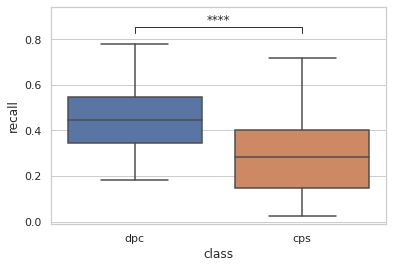

In [76]:
ax = sns.boxplot(x="class", y="recall",
                 data=all_tab)
pairs=[("dpc", "cps")]
annotator = Annotator(ax, pairs, data=all_tab, x="class", y="recall")
annotator.configure(test='Mann-Whitney', text_format='star',line_height=0.03,line_width=1)
annotator.apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DeepCell vs. CellPose: t-test independent samples, P_val:1.453e-16 t=9.039e+00


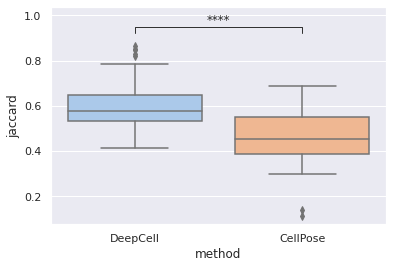

In [27]:
f("jaccard")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DeepCell vs. CellPose: t-test independent samples, P_val:1.000e+00 t=0.000e+00


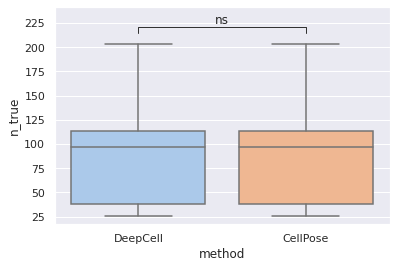

In [28]:
f("n_true")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DeepCell vs. CellPose: t-test independent samples, P_val:3.217e-13 t=7.813e+00


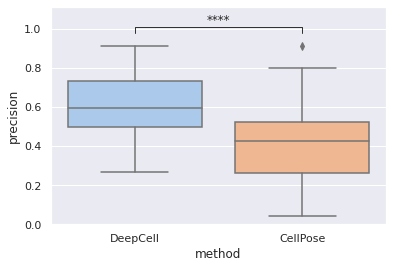

In [29]:
f("precision")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DeepCell vs. CellPose: t-test independent samples, P_val:3.776e-11 t=7.005e+00


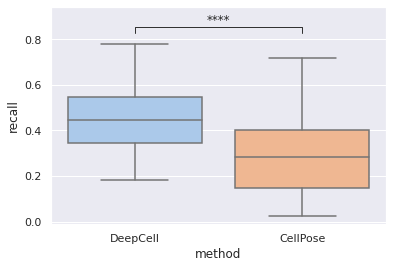

In [30]:
f("recall")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DeepCell vs. CellPose: t-test independent samples, P_val:1.902e-12 t=7.517e+00


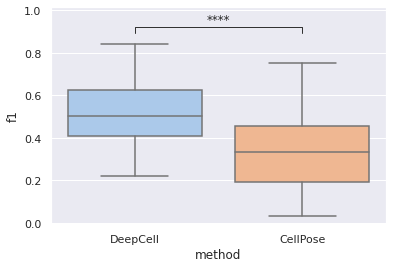

In [31]:
f("f1")